In [16]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pickle
import h5py
import glob
import matplotlib.pyplot as plt
from chainconsumer.chainconsumer import ChainConsumer
from ceffyl.chain_utils import chain_utils
import la_forge.core as co
import la_forge.diagnostics as dg
from emcee.autocorr import integrated_time
import os

import sys
sys.path.append('/home/lambwg/holodeck/holodeck/gps/')
import gp_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## define your library

In [3]:
# define location to library
library = '/home/lambwg/ng15yr_astro_interp/spec_libraries/uniform-07a_new_n500_r100_f40/'
library_nickname = 'uniform-07a_new_n500_r100_f40'

## which data set are you fitting to?

In [4]:
ceffyl_data = '/home/lambwg/ng15yr_astro_interp/ceffyl_data/30f_fs{hd}_ceffyl/'
ceffyl_nickname = 'fs[HD]_DMX'

## how many frequencies?

In [5]:
Nfreq = [5]

## outdir of your analyses

In [6]:
outdir = '/data/taylor_group/william_lamb/ng15_astro_interp/prod_runs/uniform-07a_new_n500_r100_f40/fshd_dmx/'

## load gp and var_gps

In [7]:
# find gp george pickles in libeary
gp_george_pkl = glob.glob(library+'*med*.pkl')
var_gp_george_pkl = glob.glob(library+'*std*.pkl')

In [8]:
# open spectra file
#spectra = h5py.File(library+'/sam_lib.hdf5')
spectra = None

In [9]:
# open gp_george objects
gp_george = pickle.load(open(gp_george_pkl[0], 'rb'))
var_gp_george = pickle.load(open(var_gp_george_pkl[0], 'rb'))

In [10]:
# make gaussproc objects
gp = gp_utils.set_up_predictions(spectra, gp_george)
var_gp = gp_utils.set_up_predictions(spectra, var_gp_george)

##### make a title

In [11]:
titles = [f'{library_nickname} | {ceffyl_nickname} | {n}f'
          for n in Nfreq]

##### also... need frequencies

In [37]:
Tspan = 16.04 * 365.24 * 24 * 60 * 60
freqs = np.arange(1, 31)/Tspan

##### function to check if chain is finished for compression and deletion

In [13]:
import os
def compressor(chaindir, savecore='chain.core'):
    """
    function to compress and delete chain*.txt files
    if they have been sampled enough
    """
    core = co.Core(chaindir)
    core.save(chaindir+f'/{savecore}')
    print(f'Saved {chaindir}/{savecore}')
    
    deleted = False
    
    Rhat, idx = dg.grubin(core)
    acls = np.array([integrated_time(core(p), quiet=True)
                     for p in core.params[:-4]])
    if len(idx) == 0 and acls.max() < 50 and core.chain.shape[0] > 100000:
        os.system(f'rm {chaindir}/chain_1.*')
        print(f'Deleted {chaindir}/chain.txt')
        deleted = True
    
    return core, deleted

# plot settings

In [14]:
# latex labels
tex = [r'$\tau_\mathrm{hard}$', r'$\phi_{0,\mathrm{GSMF}}$',
       r'$\log_{10}M_{0,\mathrm{GSMF}}$', r'$\log_{10}A_\mathrm{mmb}$',
       r'$\mathrm{mmb-scatter}$']

In [15]:
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

figsize = 6
fontsize = 13

mpl.style.use('default')   # avoid dark backgrounds from dark theme vscode
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.25
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = fontsize
plt.rcParams["legend.fontsize"] = fontsize*0.8
plt.rcParams["legend.handlelength"] = 1.5
plt.rcParams["lines.solid_capstyle"] = 'round'
mpl.rcParams['xtick.labelsize'] = fontsize*0.8
mpl.rcParams['ytick.labelsize'] = fontsize*0.8

figsize_single = [figsize, figsize * (np.sqrt(5)-1)/2]
adjust_single = dict(left=0.12, bottom=0.15, right=0.95, top=0.95)

figsize_double = [2*fss for fss in figsize_single]
adjust_double = dict(left=0.08, bottom=0.10, right=0.98, top=0.95)

## check your chains

In [21]:
os.path.isfile(outdir+f'5f/chain.core')

True

Loading /data/taylor_group/william_lamb/ng15_astro_interp/prod_runs/uniform-07a_new_n500_r100_f40/fshd_dmx/5f
These are your 5 parameters:...
['hard_time', 'gsmf_phi0', 'gsmf_mchar0_log10', 'mmb_mamp_log10', 'mmb_scatter_dex']



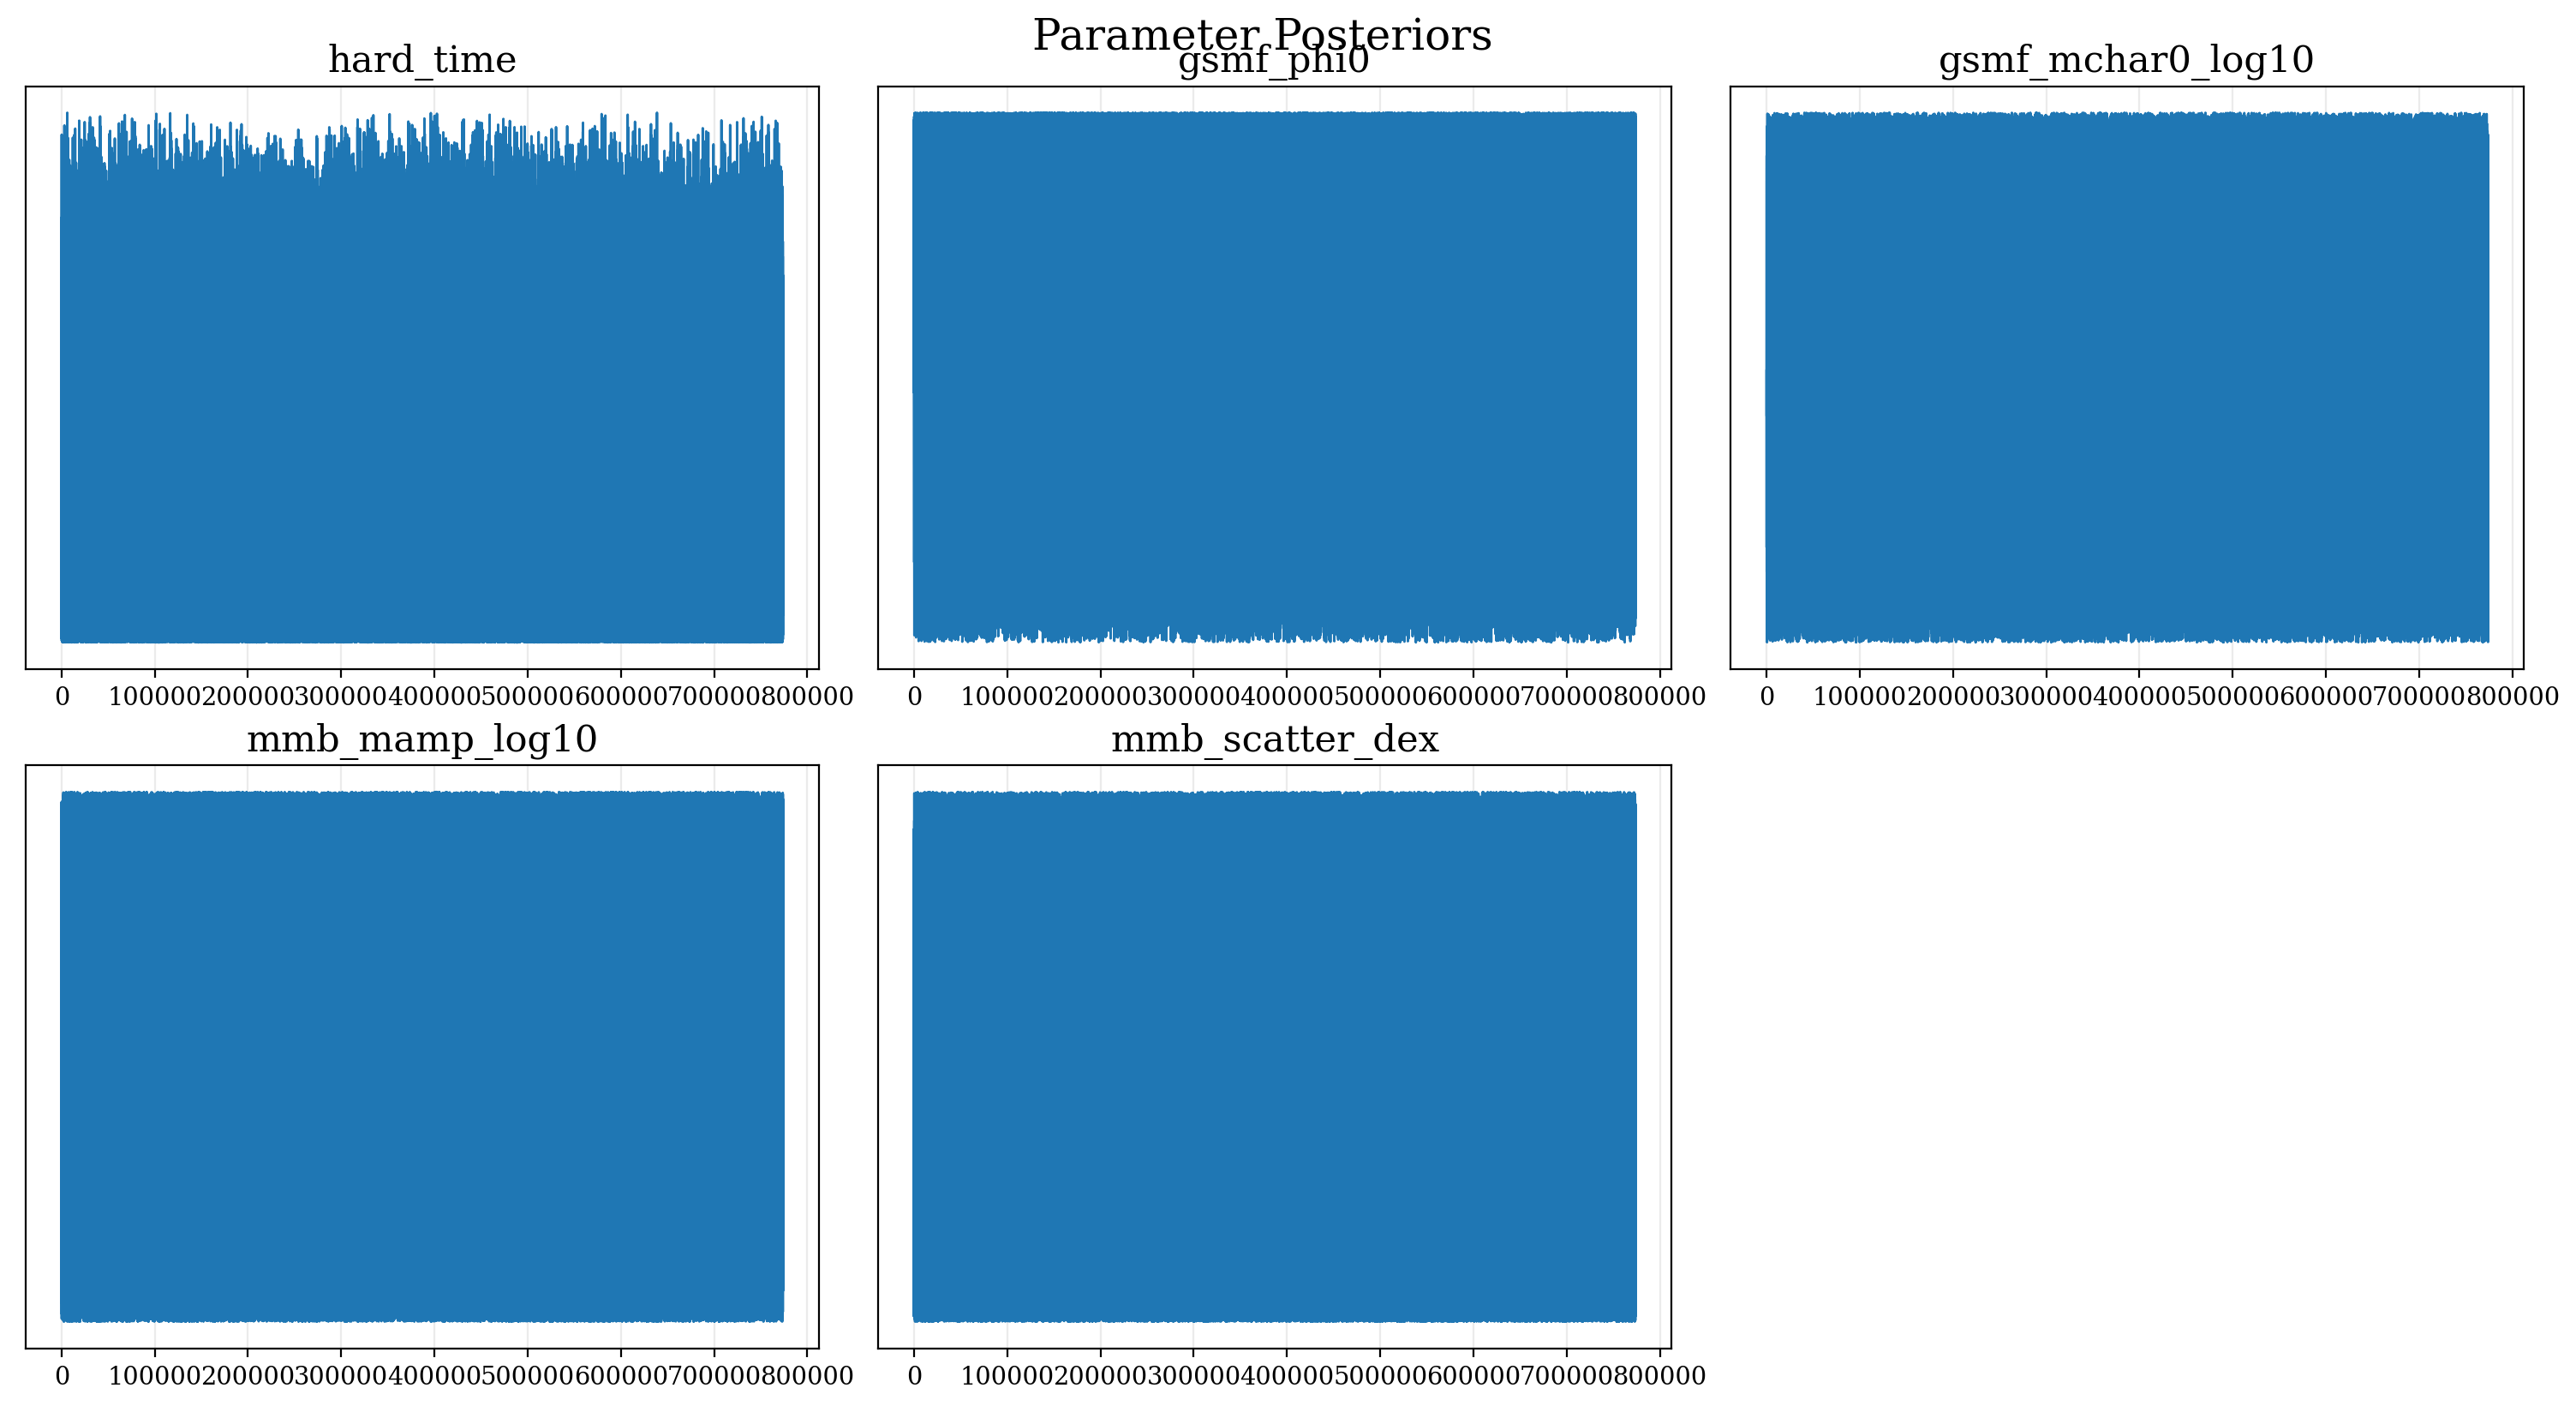

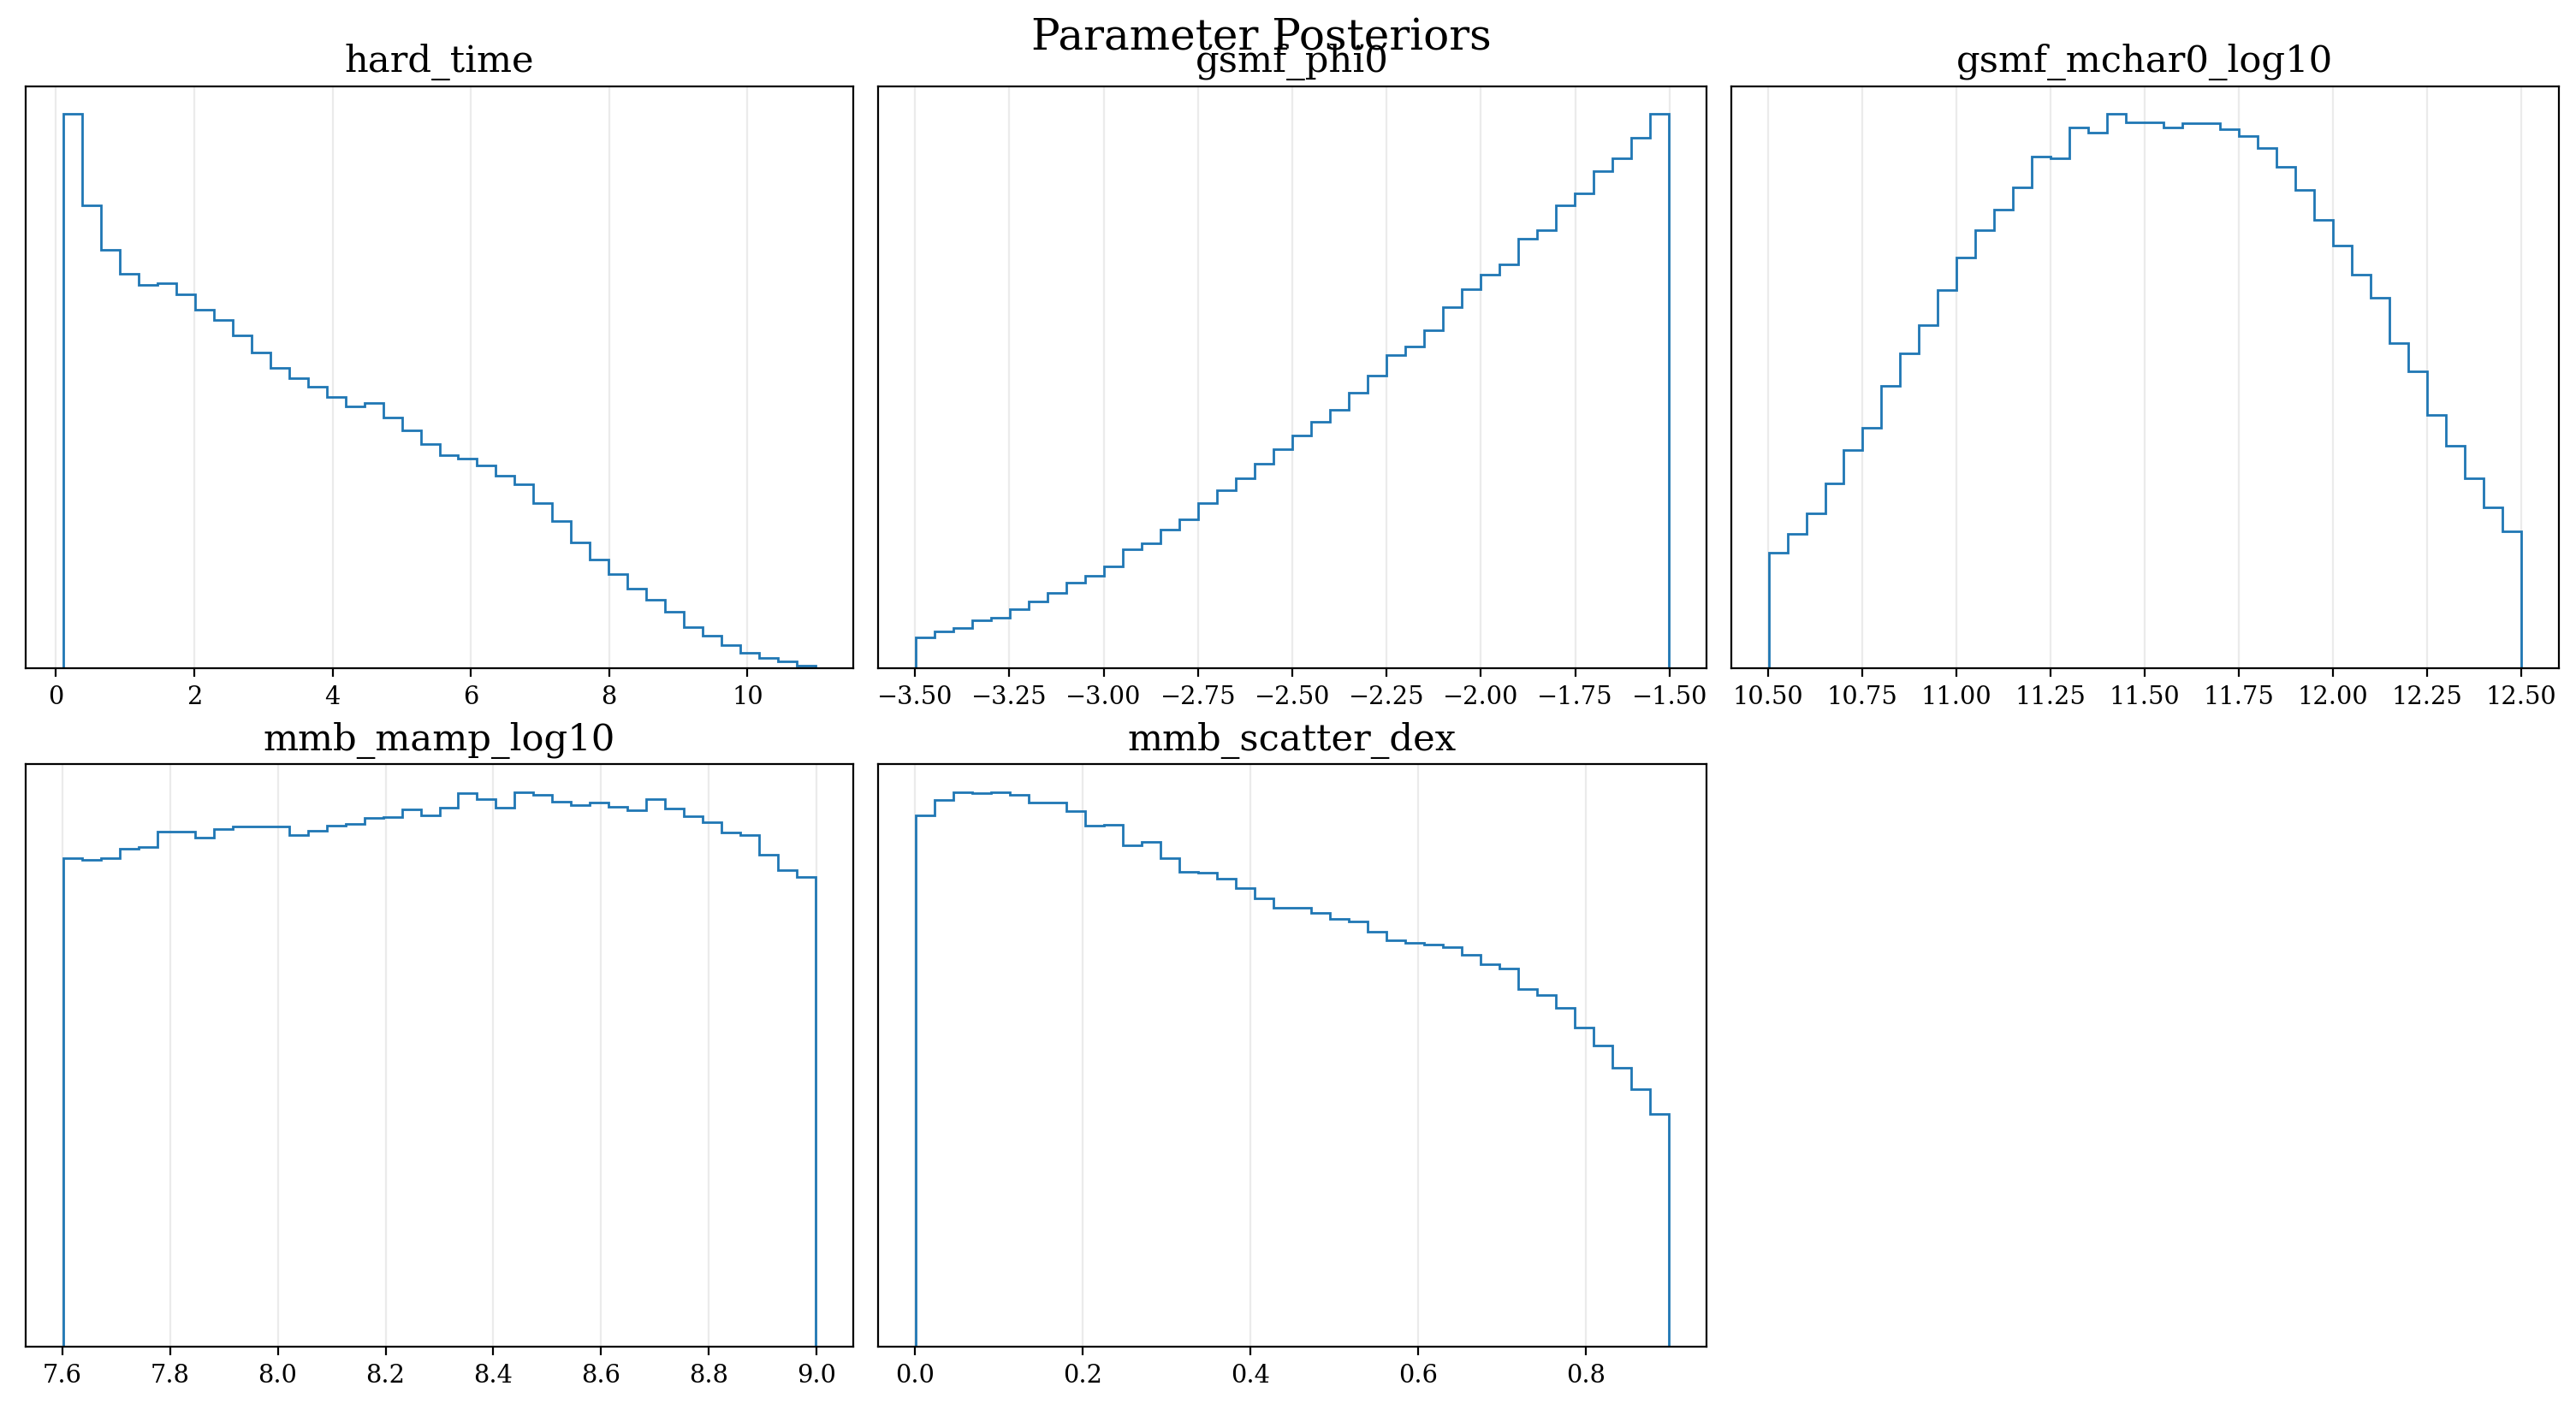

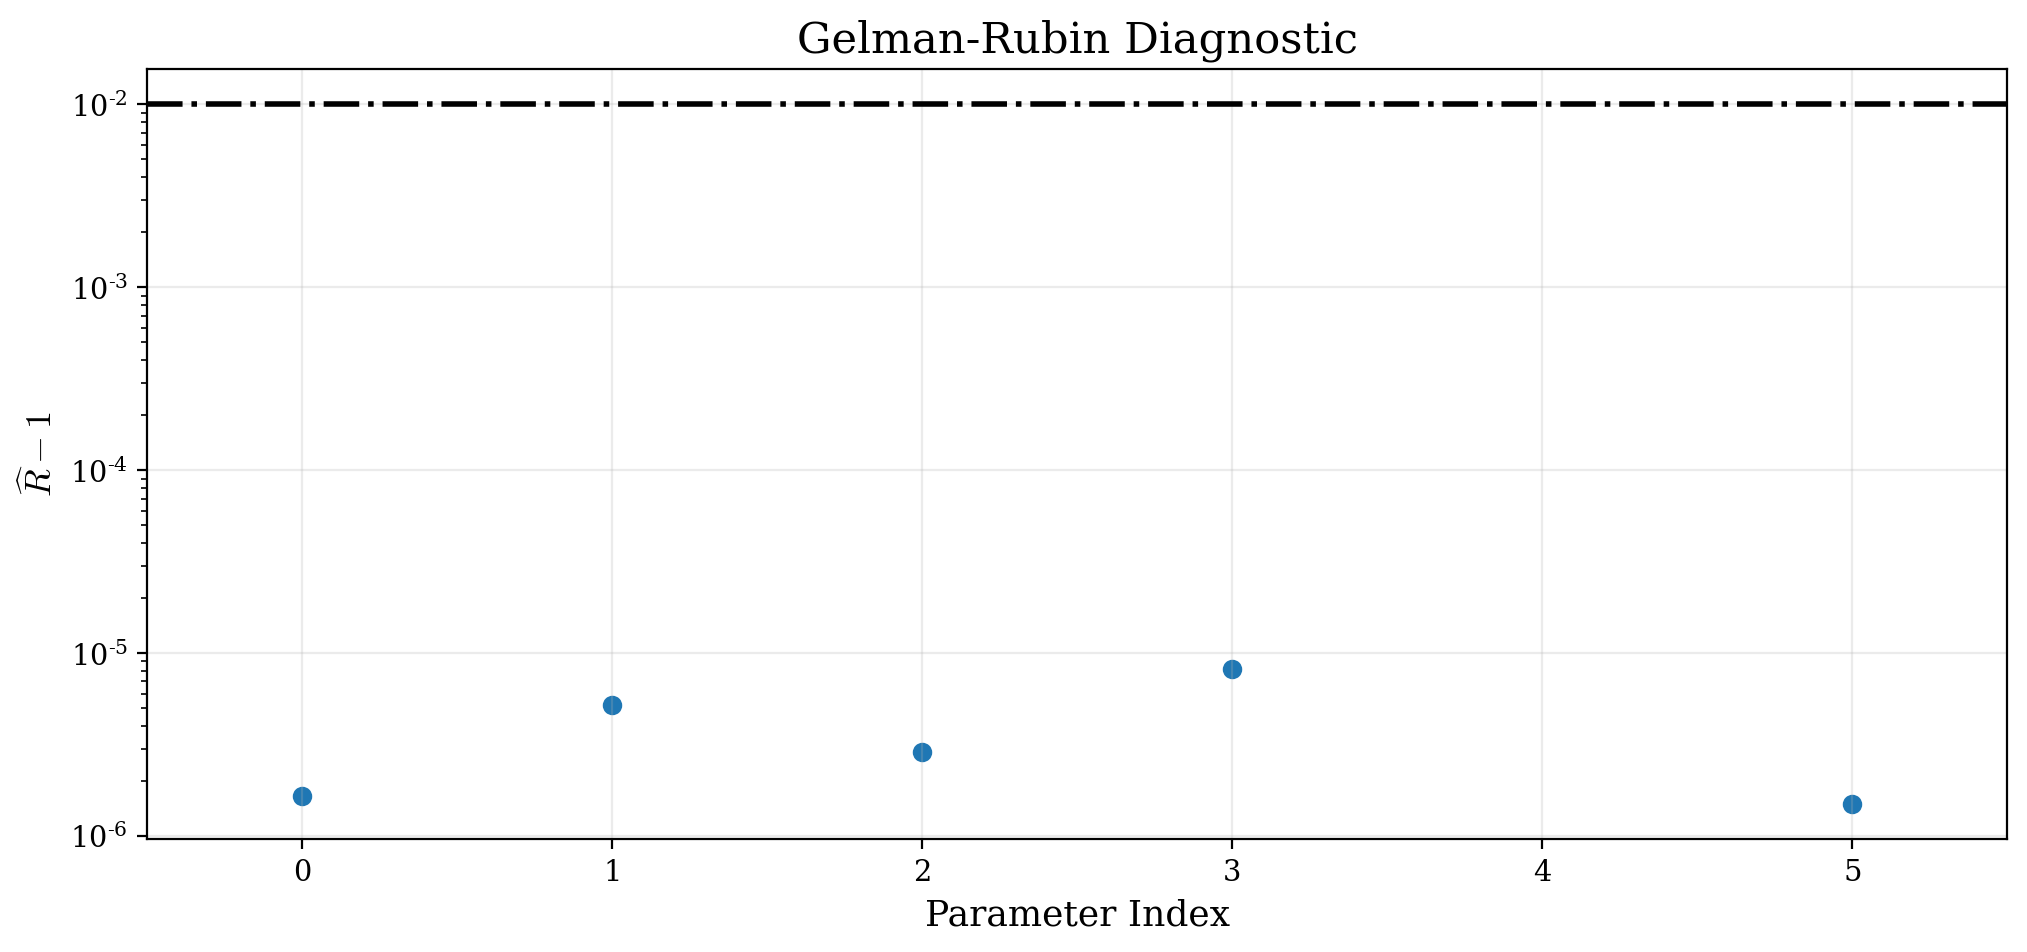

Min/max Gelman-Rubin tests: (0.9999995910055594, 1.0000081934296525)

Min/max autocorrelation lengths: (7.121731683531442, 11.676532097005406)



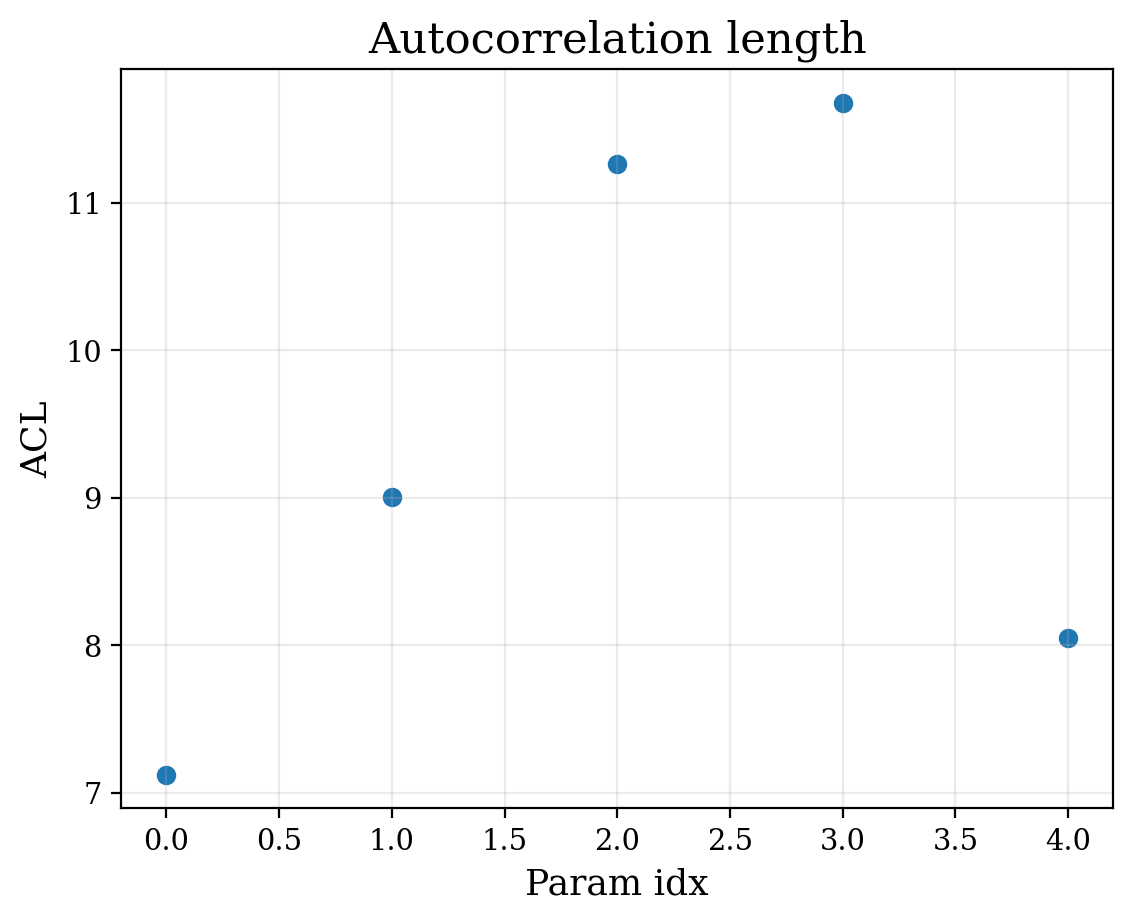

In [23]:
chains = []
for f in Nfreq:
    print(f"Loading {outdir+f'{f}f'}")
    
    # checking if file has already been compressed
    if os.path.isfile(outdir+f'{f}f/chain.core'):
        chains.append(chain_utils(corepath=outdir+f'{f}f/chain.core'))
    
    else:  # compress file, load, and delete chain.txt
        chains.append(chain_utils(outdir+f'{f}f'))
        compressor(outdir+f'{f}f')

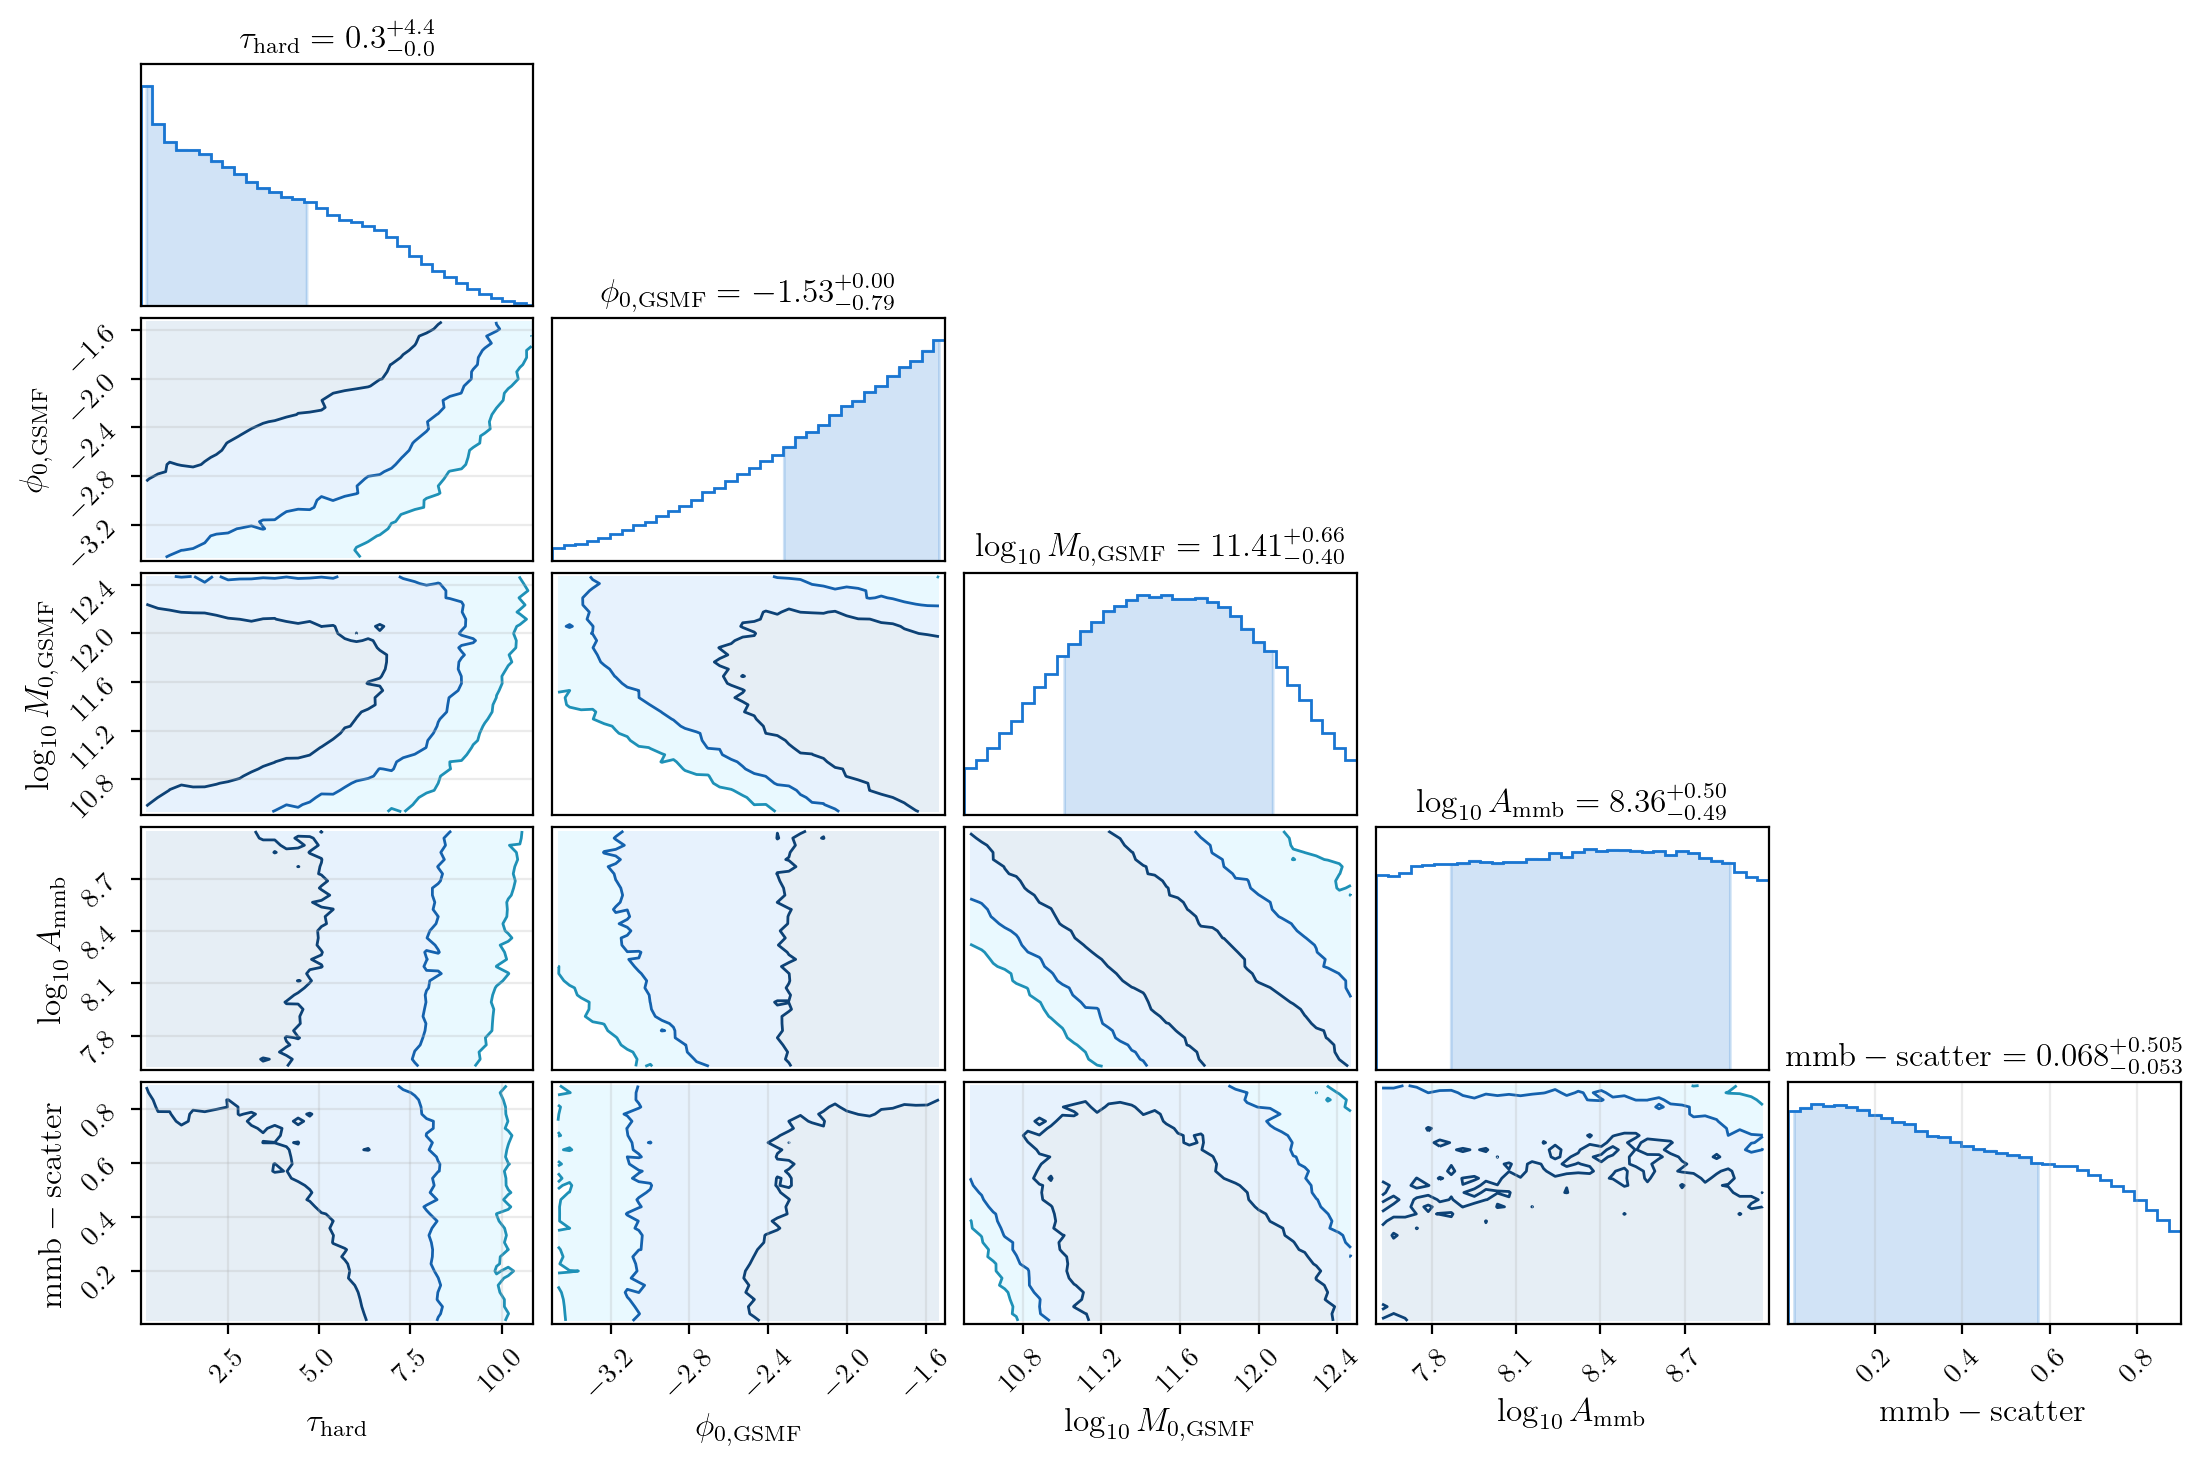

In [24]:
for chain in chains:
    pars = chain.params[:-4]
    
    c = ChainConsumer()
    c.add_chain(chain(pars), parameters=tex)
    c.configure(smooth=False, sigmas=[1,2,3],
                shade_alpha=0.1, summary=True)
    c.plotter.plot(figsize=figsize_double);

## plot max like on violins

In [33]:
def plot_violin(freespec, refit, freqs, Tspan, num_reals, Nfreq,
                gp, gp_george, var_gp, var_gp_george, pars,
                figsettings=adjust_single, title=''):
    """
    func to plot max like, random reals onto free spec
    """
    
    fig, ax = plt.subplots(figsize=figsize_single)
    plt.subplots_adjust(**figsettings)
    
    ax.set(xlabel='$\log_{10}$ (GW frequency [Hz])',
           ylabel='$\log_{10}$ (CP delay [s])',
           ylim=[-9, -5.8], title=title)

    # plot violinplot of data
    ax.violinplot(freespec([p for p in freespec.params if 'rho' in p][:Nfreq]),
                  positions=np.log10(freqs[:Nfreq]), widths=0.1);
    
    # find max likelihood params
    maxLidx = np.where(refit('lnpost').max()==refit('lnpost'))[0][0]
    maxL = refit(pars)[maxLidx]

    # predict max likelihood spectrum
    max_spec = gp_utils.hc_from_gp(gp_george[:Nfreq], gp[:Nfreq],
                                   var_gp_george[:Nfreq], var_gp[:Nfreq],
                                   maxL)
    max_log10rho = 0.5*np.log10(max_spec[0]**2/(12*np.pi**2*freqs[:Nfreq]**3*Tspan))
    
    # plot max likelihood spectrum
    ax.plot(np.log10(freqs[:Nfreq]), max_log10rho, c='k')
    sigma = 0.5 * max_spec[2][:,1][:Nfreq]
    ax.fill_between(np.log10(freqs[:Nfreq]), max_log10rho-sigma,
                    max_log10rho+sigma, alpha=0.5, color='k')

    # plot random realisations onto the violins
    for ii in range(num_reals):
        idx = np.random.choice(refit('lnpost').shape[0])
        params = refit(pars)[idx]

        spec = gp_utils.hc_from_gp(gp_george[:Nfreq], gp[:Nfreq],
                                   var_gp_george[:Nfreq], var_gp[:Nfreq],
                                   params)
        log10rho = 0.5*np.log10(spec[0]**2/(12*np.pi**2*freqs[:Nfreq]**3*Tspan))

        ax.plot(np.log10(freqs[:Nfreq]), log10rho, c='C1', alpha=0.1)

        sigma = 0.5 * spec[2][:,1][:Nfreq]
        ax.fill_between(np.log10(freqs[:Nfreq]), max_log10rho-sigma,
                        max_log10rho+sigma, alpha=0.05, color='C1')
    
    return

In [34]:
fspath='/data/taylor_group/william_lamb/analyses/NANOGrav/NG15_v1p1/freespec/30fCP_30fiRN_3A/chain.core'
freespec = co.Core(corepath=fspath)

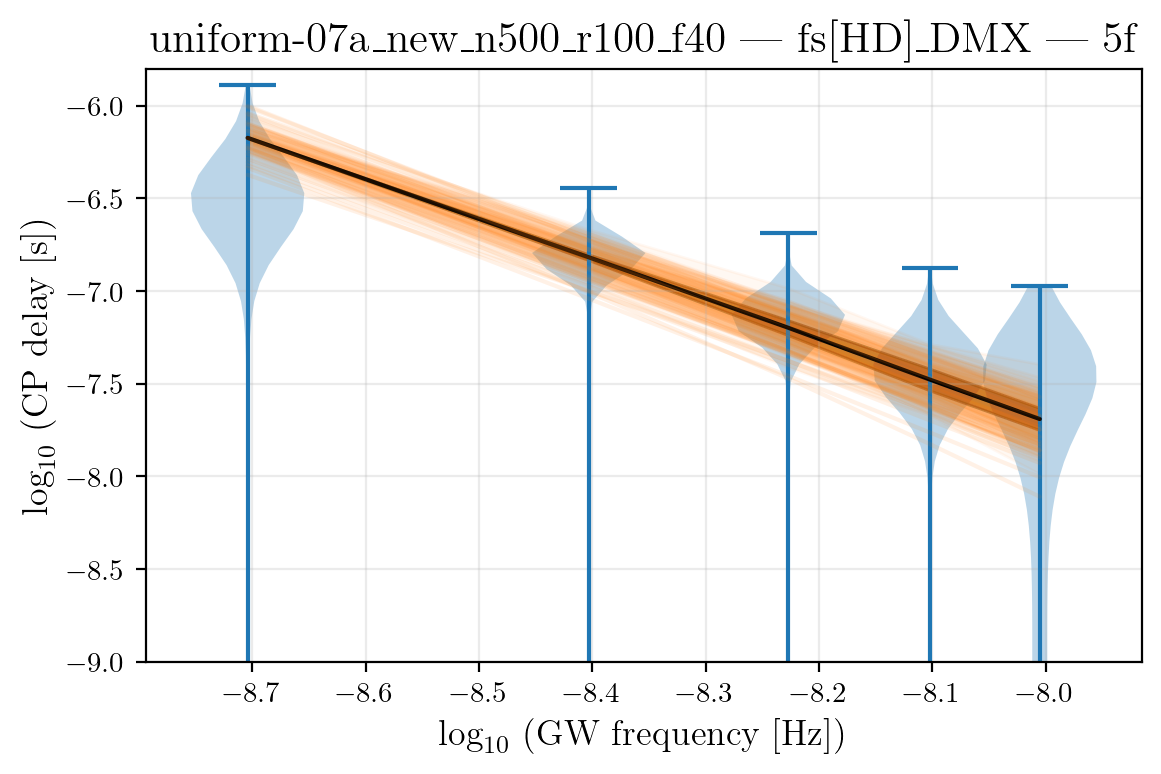

In [38]:
for chain, nfreq, t in zip(chains, Nfreq, titles):
    pars = chain.params[:-4]
    
    plot_violin(freespec=freespec,
                refit=chain,
                freqs=freqs, Tspan=Tspan,
                num_reals=20, Nfreq=nfreq,
                gp=gp, gp_george=gp_george,
                var_gp=var_gp, var_gp_george=var_gp_george,
                pars=pars, title=t);